In [1]:
%pylab inline
from siph import *



import h5py
import condor

/Users/hantke/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_data(experiment, run_number, N=50, skip=1):
    filename = "/Users/hantke/davinci/scratch/fhgfs/xray/%s/preproc/%s_r%04i_ol3.h5" % (experiment,experiment,run_number)
    with h5py.File(filename, "r") as f:
        imgs = asarray(f["entry_1/data_1/data"][-N-skip:-skip])
        msk = asarray(f["entry_1/data_1/mask"])
        gains = asarray(f["entry_1/detector_1/gain"][-N-skip:-skip])
        photon_energies_SLAC = asarray(f["entry_1/FEL/photon_energy_eV_SLAC"][-N-skip:-skip])
        gmds = asarray(f["entry_1/detector_3/pulse_energy_mJ"][-N-skip:-skip])
    return imgs, msk, gains, photon_energies_SLAC, gmds

def generate_mask(msk, rlims=None):
    tmp = (msk&condor.utils.pixelmask.PixelMask.PIXEL_IS_IN_MASK)==0
    tmp[:512,512:] = False
    if rlims is not None:
        X, Y = meshgrid(arange(msk.shape[1]), arange(msk.shape[0]))
        R = sqrt((X-530)**2 + (Y-550)**2)
        tmp *= (R >= rlims[0])*(R <= rlims[1])
    return tmp
        
def apply_mask(imgs, msk, rlims=None):
    tmp = repeat(asarray([msk]), imgs.shape[0], axis=0)
    values = imgs.flatten()[tmp.flatten()]
    return values
    

(0, 1000)

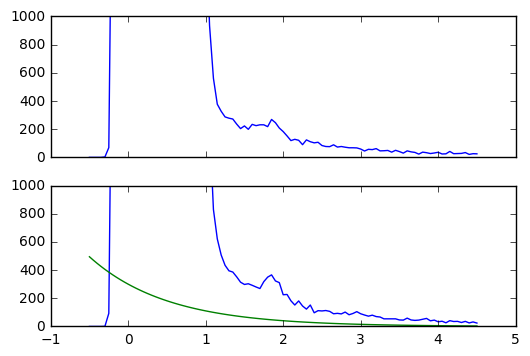

In [178]:
nbins = 101
ex = "amol3416"
N = 10

fig, axs = subplots(2, 1, sharey=True, sharex=True)

# No gas
r = 154
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
msk = generate_mask(msk)
values = apply_mask(imgs, msk, rlims=(50, 300))
photons = values / gains.mean()
I_no, H_no = histogram(photons, nbins=nbins, vmax=4.5)
axs[0].plot(I_no, H_no)

# Only N2
r = 152
imgs, msk, gains, photon_energies_SLAC, gmds = read_data(ex, r, N, skip=2000)
msk = generate_mask(msk)
values = apply_mask(imgs, msk)#, rlims=(50, 300))
photons = values / gains.mean()
I_N2, H_N2 = histogram(photons, nbins=nbins, vmax=4.5)
axs[1].plot(I_N2, H_N2)

axs[1].plot(I_N2, 300*exp(-I_N2))

#from python_tools import gentools 
#[A0, x0, sigma], Hest = gentools.gaussian_fit(I, H)
#print "A0", A0
#print "x0", x0
#print "sigma", sigma
#print I.shape,H.shape

ylim(0, 1000)

In [179]:
wl_O_Kalpha = 2.362E-9
wl_N_Kalpha = 3.16E-9
wl_C_Kalpha = 4.47E-9
EeV_O_Kalpha = condor.source.Photon(wavelength=wl_O_Kalpha).get_energy_eV()
EeV_N_Kalpha = condor.source.Photon(wavelength=wl_N_Kalpha).get_energy_eV()
EeV_C_Kalpha = condor.source.Photon(wavelength=wl_C_Kalpha).get_energy_eV()
EeV_photon = np.median(photon_energies_SLAC)
photon_energyO = EeV_O_Kalpha/EeV_photon
photon_energyN = EeV_N_Kalpha/EeV_photon
photon_energyC = EeV_C_Kalpha/EeV_photon

(1027, 1056)


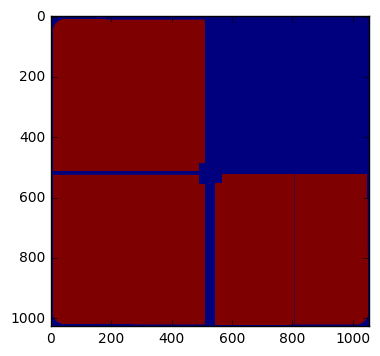

In [180]:
print msk.shape
imshow(msk)

In [156]:
def hist_I_N(N, sigma, L, nphotons_list, noise_sigma=None, nbins=101, photon_energy=1.0, vmin=-0.5, vmax=1.5):
    H = 0.
    for i,nphotons in enumerate(nphotons_list):
        I, h = hist_I(sigma, L, nphotons, noise_sigma, nbins, photon_energy*(i+1), vmin, vmax)
        H = H + h
    return I, H

def fit_hist_S(I, H, S, sigma=0.2, L=3, noise_sigma=0.1, photon_energy=1.0, N=1):
    assert len(I) == len(H)
    nbins = len(I)
    nphotons = H.sum()

    # 1) Simple Gaussian fit for getting good estimate for noise_sigma
    S0 = I <= 0.25
    func = lambda noise_sigma: 1-scipy.stats.pearsonr(np.exp(-I[S0]**2/(2.*noise_sigma**2)), H[S0])[0]
    noise_sigma_fit = scipy.optimize.leastsq(func, noise_sigma)[0][0]
    print noise_sigma_fit
    # 2) Now fit of the other variables
    x0 = [sigma, L]
    for i in range(N):
        x0 += [nphotons/N]
    #func1 = lambda x: (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
    #                            nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] - H)[S]
    #func2 = lambda x: (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
    #                            nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] + H)[S]
    #func = lambda x: func1(x)/func2(x)
    
    func = lambda x: ((hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
                                nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] - H)[S])
#                      (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
#                                nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] + H)[S])
    assert np.isnan(func(x0).any()) == False
    x_fit = scipy.optimize.leastsq(func, x0,
                                   args=(), Dfun=None,
                                   full_output=0, col_deriv=0,
                                   ftol=1.49012e-08, xtol=1.49012e-08, gtol=0.0, 
                                   maxfev=0, epsfcn=None, factor=100, diag=None)[0]
    sigma_fit = x_fit[0]
    L_fit = x_fit[1]
    nphotons_fit_list = list(x_fit[2:])
    return sigma_fit, L_fit, nphotons_fit_list, noise_sigma_fit


#sigma0 = 0.25
#L0 = 10
#noise_sigma0 = 0.2
sigma0 = 0.2
L0 = 20
noise_sigma0 = 0.05
N = 4
#sigma_fit, L_fit, nphotons_fit, noise_sigma_fit = fit_hist_S(I_no, H_no, ((I_no>0.25)*(I_no<1.25)), sigma=sigma0, L=L0, 
#                                                             noise_sigma=noise_sigma0)
#sigma_fit_2nd, L_fit_2nd, nphotons_fit_2nd, noise_sigma_fit = fit_hist_S(I_no, H_no, (I_no>1.25), sigma=sigma0, L=L0, 
#                                                             noise_sigma=noise_sigma0, photon_energy=2.)
sigma_fit, L_fit, nphotons_fit_list, noise_sigma_fit = fit_hist_S(I_no, H_no, ((I_no>0.5)),
                                                                  sigma=sigma0, L=L0, 
                                                                  noise_sigma=noise_sigma0, N=N)
H_sum_fit = 0
for i, nphotons_i_fit in enumerate(nphotons_fit_list):
    Ii_fit, Hi_fit = hist_I(sigma_fit, L_fit, abs(nphotons_i_fit), noise_sigma=noise_sigma_fit, nbins=nbins,
                            photon_energy=1.+i, vmin=I_no[0], vmax=I_no[-1])
    H_sum_fit = H_sum_fit + Hi_fit
    plot(Ii_fit, Hi_fit, "--", color="black")

semilogy(Ii_fit, H_sum_fit, color="red")
semilogy(I_no, H_no)
ylim(10, 40000000)
print sigma_fit, L_fit, nphotons_fit_list, noise_sigma_fit




In [181]:
p = lambda lam, n: lam**n*exp(-lam)/factorial(n)    
nph = lambda nph0, lam, n: nph0 * p(lam,n)/p(lam, 1)

def hist_I_N(N, sigma, L, nphotons, lam, noise_sigma=None, nbins=101, photon_energy=1.0, vmin=-0.5, vmax=1.5):
    H = 0.
    for i in range(1, N+1):
        print lam, i
        print p(lam, i)
        print p(lam, 1)
        print nph(nphotons, lam, i)
        I, h = hist_I(sigma, L, int(nph(nphotons, lam, i)), noise_sigma, nbins, photon_energy*i, vmin, vmax)
        H = H + h
    return I, H

def fit_hist_S(I, H, S, sigma=0.2, L=3, lam=0.6, noise_sigma=0.1, photon_energy=1.0, N=1):
    assert len(I) == len(H)
    nbins = len(I)
    nphotons = H.sum()

    # 1) Simple Gaussian fit for getting good estimate for noise_sigma
    S0 = I <= 0.25
    func = lambda noise_sigma: 1-scipy.stats.pearsonr(np.exp(-I[S0]**2/(2.*noise_sigma**2)), H[S0])[0]
    noise_sigma_fit = scipy.optimize.leastsq(func, noise_sigma)[0][0]
    print noise_sigma_fit
    # 2) Now fit of the other variables
    x0 = [sigma, L, nphotons, lam]
    # Poisson
    
    #func1 = lambda x: (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
    #                            nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] - H)[S]
    #func2 = lambda x: (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
    #                            nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] + H)[S]
    #func = lambda x: func1(x)/func2(x)
    
    func = lambda x: ((hist_I_N(N, sigma=x[0], L=x[1], nphotons=x[2], lam=x[3], noise_sigma=noise_sigma_fit,
                                nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] - H)[S])
#                      (hist_I_N(N, sigma=x[0], L=x[1], nphotons_list=x[2:], noise_sigma=noise_sigma_fit,
#                                nbins=nbins, photon_energy=photon_energy, vmin=I[0], vmax=I[-1])[1] + H)[S])
    assert np.isnan(func(x0).any()) == False
    x_fit = scipy.optimize.leastsq(func, x0,
                                   args=(), Dfun=None,
                                   full_output=0, col_deriv=0,
                                   ftol=1.49012e-08, xtol=1.49012e-08, gtol=0.0, 
                                   maxfev=0, epsfcn=None, factor=100, diag=None)[0]
    sigma_fit, L_fit, nphotons_fit, lam_fit = x_fit
    return sigma_fit, L_fit, nphotons_fit, lam_fit, noise_sigma_fit

0.0540450837984
0.6 1
0.329286981656
0.329286981656
7474110.0
0.6 2
0.0987860944969
0.329286981656
2242233.0
0.6 3
0.0197572188994
0.329286981656
448446.6
0.6 4
0.00296358283491
0.329286981656
67266.99
0.6 5
0.000355629940189
0.329286981656
8072.0388
0.6 1
0.329286981656
0.329286981656
7474110.0
0.6 2
0.0987860944969
0.329286981656
2242233.0
0.6 3
0.0197572188994
0.329286981656
448446.6
0.6 4
0.00296358283491
0.329286981656
67266.99
0.6 5
0.000355629940189
0.329286981656
8072.0388
0.6 1
0.329286981656
0.329286981656
7474110.0
0.6 2
0.0987860944969
0.329286981656
2242233.0
0.6 3
0.0197572188994
0.329286981656
448446.6
0.6 4
0.00296358283491
0.329286981656
67266.99
0.6 5
0.000355629940189
0.329286981656
8072.0388
0.6 1
0.329286981656
0.329286981656
7474110.0
0.6 2
0.0987860944969
0.329286981656
2242233.0
0.6 3
0.0197572188994
0.329286981656
448446.6
0.6 4
0.00296358283491
0.329286981656
67266.99
0.6 5
0.000355629940189
0.329286981656
8072.0388
0.6 1
0.329286981656
0.329286981656
7474110.

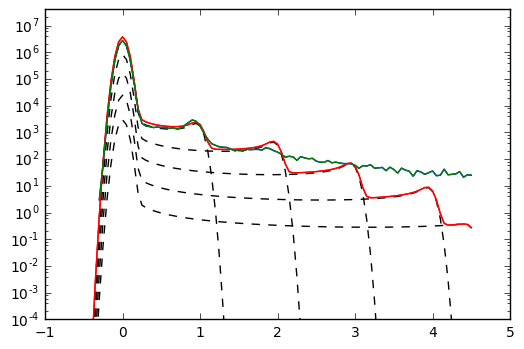

In [196]:
#sigma0 = 0.25
#L0 = 10
#noise_sigma0 = 0.2
sigma0 = 0.2
L0 = 20
noise_sigma0 = 0.05
lam0 = 0.6
N = 5
#sigma_fit, L_fit, nphotons_fit, noise_sigma_fit = fit_hist_S(I_no, H_no, ((I_no>0.25)*(I_no<1.25)), sigma=sigma0, L=L0, 
#                                                             noise_sigma=noise_sigma0)
#sigma_fit_2nd, L_fit_2nd, nphotons_fit_2nd, noise_sigma_fit = fit_hist_S(I_no, H_no, (I_no>1.25), sigma=sigma0, L=L0, 
#                                                             noise_sigma=noise_sigma0, photon_energy=2.)
sigma_fit, L_fit, nphotons_fit, lam_fit, noise_sigma_fit = fit_hist_S(I_no, H_no, ((I_no>0.5)),
                                                                      sigma=sigma0, L=L0, lam=lam0,
                                                                      noise_sigma=noise_sigma0, N=N)
print sigma_fit, L_fit, nphotons_fit, lam_fit, noise_sigma_fit

H_sum_fit = 0
for i in range(1, N+1):
    Ii_fit, Hi_fit = hist_I(sigma_fit, L_fit, abs(int(nph(nphotons_fit, lam_fit, i))), noise_sigma=noise_sigma_fit, nbins=nbins,
                            photon_energy=i, vmin=I_no[0], vmax=I_no[-1])
    H_sum_fit = H_sum_fit + Hi_fit
    plot(Ii_fit, Hi_fit, "--", color="black")





0.156617619112 20.4916655613 [18182211.517612219, 2841276.1761494591, 1472482.2959561485, 1263850.9693822162] 0.0540450837984


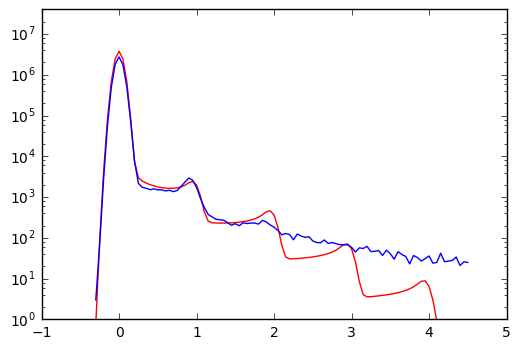

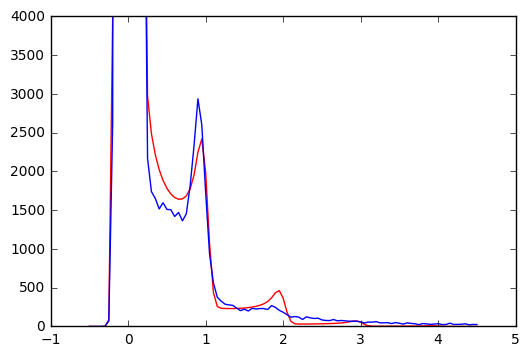

In [202]:
semilogy(Ii_fit, H_sum_fit, color="red")
semilogy(I_no, H_no)
ylim(1, 40000000)

figure()

plot(Ii_fit, H_sum_fit, color="red")
plot(I_no, H_no)
ylim(0, 4000)

print sigma_fit, L_fit, nphotons_fit_list, noise_sigma_fit


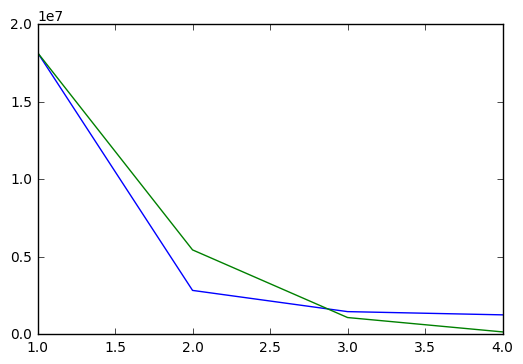

In [153]:
from scipy.misc import factorial
n = arange(1, 5)
p = lambda l: l**n*exp(-l)/factorial(n)
plot(n, nphotons_fit_list)
l = 0.6
plot(n, p(l)/p(l)[0]*nphotons_fit_list[0])

(0, 1000)

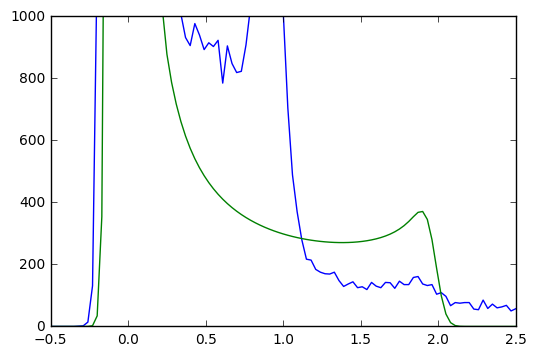

In [101]:
sigma_g = 0.2
L_g = 10.
noise_sigma_g = 0.05
nphotons_list_g = [0, 0, 1000000]
I_g, H_g = hist_I_N(3, sigma_g, L_g, nphotons_list_g, noise_sigma_g, nbins=nbins, photon_energy=1.0, vmin=-0.5, vmax=2.5)
plot(I_no, H_no)
plot(I_g, H_g)
ylim(0, 1000)

In [156]:
hist_I_1 = lambda L, nphotons, noise_sigma: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma,
                                                   nbins=nbins, photon_energy=1.0)[1]



hist_I_N = lambda L, nphotons, noise_sigma: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma,
                                                   nbins=nbins, photon_energy=photon_energyN)[1]
#hist_I_C = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
#                                             nbins=nbins, photon_energy=photon_energyC)[1]
#hist_I_O = lambda L, nphotons: hist_I(sigma_fit, L, nphotons, noise_sigma=noise_sigma_fit,
#                                             nbins=nbins, photon_energy=photon_energyO)[1]
#H_sum = lambda L, nphotons1, nphotonsN, nphotonsC, nphotonsO: hist_I_1(abs(L), abs(nphotons1)) +\
#                                                              hist_I_N(abs(L), abs(nphotonsN)) +\
#                                                              hist_I_C(abs(L), abs(nphotonsC)) +\
#                                                              hist_I_O(abs(L), abs(nphotonsO))
H_sum = lambda L, nphotons1, nphotonsN, noise_sigma: hist_I_1(abs(L), abs(nphotons1), abs(noise_sigma)) +\
                                                     hist_I_N(abs(L), abs(nphotonsN), abs(noise_sigma))
func = lambda x: (H_N2 - H_sum(x[0], x[1], x[2], x[3]))/(H_N2 + H_sum(x[0], x[1], x[2], x[3]))
x = scipy.optimize.leastsq(func, [L_fit, 2122717.22657, 7933926.95503, noise_sigma_fit])[0]
x = abs(array(x))
[L_fit2, nphotons1_fit, nphotonsN_fit, noise_sigma_fit2] = x
print x


[  9.39759300e+00   8.18316426e+05   3.62556625e+06   6.33675045e-02]


(0, 10000)

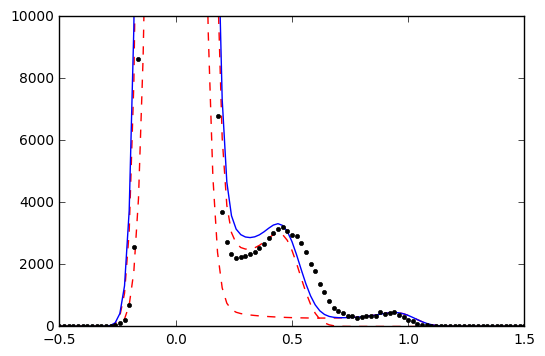

In [164]:
I = linspace(-0.5, 1.5, nbins)
H_1 = hist_I_1(L_fit2, nphotons1_fit, noise_sigma_fit2)
H_N = hist_I_N(L_fit2, nphotonsN_fit, noise_sigma_fit2)
#H_C = hist_I_C(L_fit2, nphotonsC_fit)
#H_O = hist_I_O(L_fit2, nphotonsO_fit)

I = linspace(-0.5, 1.5, nbins)
plot(I, H_1, "--", c='red')
plot(I, H_N, "--", c='red')
#plot(I, H_C, "--", c='red')
#plot(I, H_O, "--", c='red')
#plot(I, H_1+H_N+H_C+H_O)
plot(I, H_1+H_N)
plot(I, H_N2, ".", c="black")
ylim(0, 10000)

In [102]:
print L_fit2, sigma_fit, nphotons1_fit
print L_fit2, sigma_fit, nphotonsN_fit

14.0696602774 0.152528987382 2122717.22657
14.0696602774 0.152528987382 7933926.95503


In [136]:
I1_test, H1_test = generate_test_hist_I(sigma=sigma_fit, L=L_fit2, nphotons=int(nphotons1_fit), 
                                        noise_sigma=noise_sigma_fit, nbins=nbins, photon_energy=1.0)
IN_test, HN_test = generate_test_hist_I(sigma=sigma_fit, L=L_fit2, nphotons=int(nphotonsN_fit),
                                        noise_sigma=noise_sigma_fit, nbins=nbins, photon_energy=photon_energyN)
I1_ideal, H1_ideal = hist_I(sigma_fit, L_fit2, int(nphotons1_fit), 
                            noise_sigma=noise_sigma_fit, nbins=nbins, photon_energy=1.0)
IN_ideal, HN_ideal = hist_I(sigma_fit, L_fit2, int(nphotonsN_fit), 
                            noise_sigma=noise_sigma_fit, nbins=nbins, photon_energy=photon_energyN)


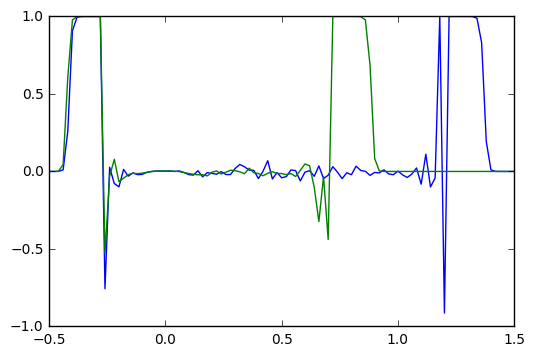

In [144]:
plot(I, (H1_ideal - H1_test)/(H1_ideal + H1_test + 1E-10))
plot(I, (HN_ideal - HN_test)/(HN_ideal + HN_test + 1E-10))

(0, 10000)

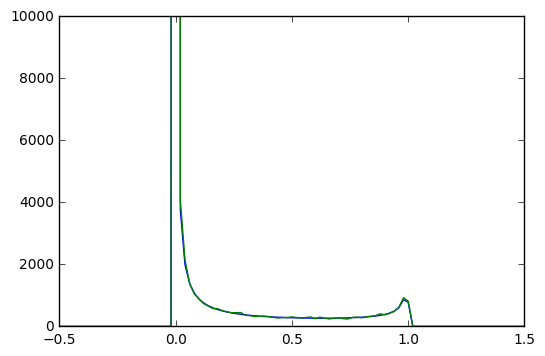

In [119]:
I1_test, H1_test = generate_test_hist_I(sigma=sigma_fit, L=L_fit2, nphotons=int(nphotons1_fit), 
                                        noise_sigma=None, nbins=nbins, photon_energy=1.0)
IN_test, HN_test = generate_test_hist_I(sigma=sigma_fit, L=L_fit2, nphotons=int(nphotonsN_fit),
                                        noise_sigma=None, nbins=nbins, photon_energy=photon_energyN)
I1_ideal, H1_ideal = hist_I(sigma_fit, L_fit2, int(nphotons1_fit), noise_sigma=None, nbins=nbins, photon_energy=1.0)
IN_ideal, HN_ideal = hist_I(sigma_fit, L_fit2, int(nphotonsN_fit), noise_sigma=None, nbins=nbins, photon_energy=photon_energyN)
plot(I, (H1_ideal - H1_test)/(H1_ideal + H1_test + 1E-10))
plot(I, (HN_ideal - HN_test)/(HN_ideal + HN_test + 1E-10))


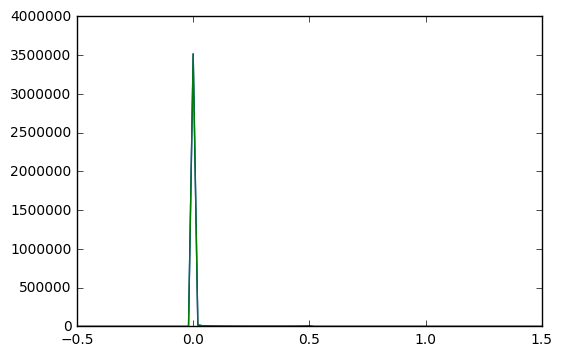

In [126]:
#plot(I1_ideal, H1_ideal)
plot(IN_ideal, HN_ideal)
#plot(I1_test, H1_test)
plot(IN_test, HN_test)
#plot(IN_ideal, H1_ideal + HN_ideal)
#ylim(0, 10000)

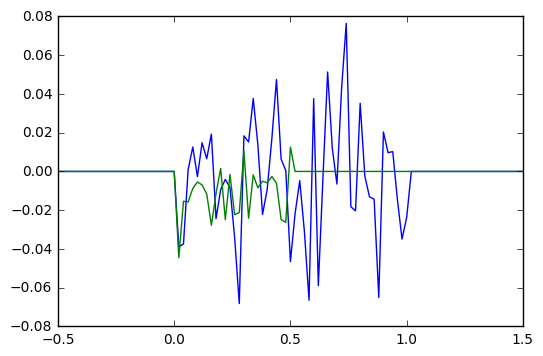